# Examples

This notebook provides some examples of how to use Time Blender.

In [1]:
from time_blender.random_events import *
from time_blender.deterministic_events import *
from time_blender.coordination_events import *

from time_blender.core import *
from time_blender.models import SimpleModels, ClassicModels, BankingModels, EconomicModels, EcologyModels

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd


/home/salem/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

Let us define a helper function to generate and plot the models.

In [3]:
def generate_and_plot(models, start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                      n=1, freq='D'):
    
    data = generate(models, start_date, end_date, n=n, freq=freq)

    # plot
    for i in range(0, n):
        data[i].plot()
        plt.show()
    

## Predefined Models

The easiest way to use TimeBlender is through the predefined models that ship with it. These are, in fact, examples of the kinds of models that can be built, so users can also take them as inspiration for their own custom models.

### Simple Models

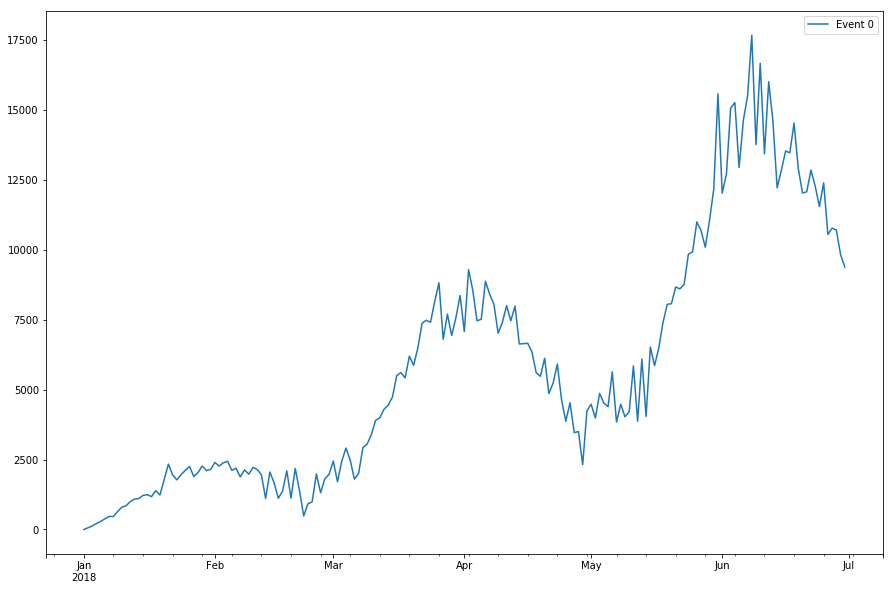

In [4]:
model = SimpleModels.cycle()
generate_and_plot(model, n=1)

### Classic Models: ARMA

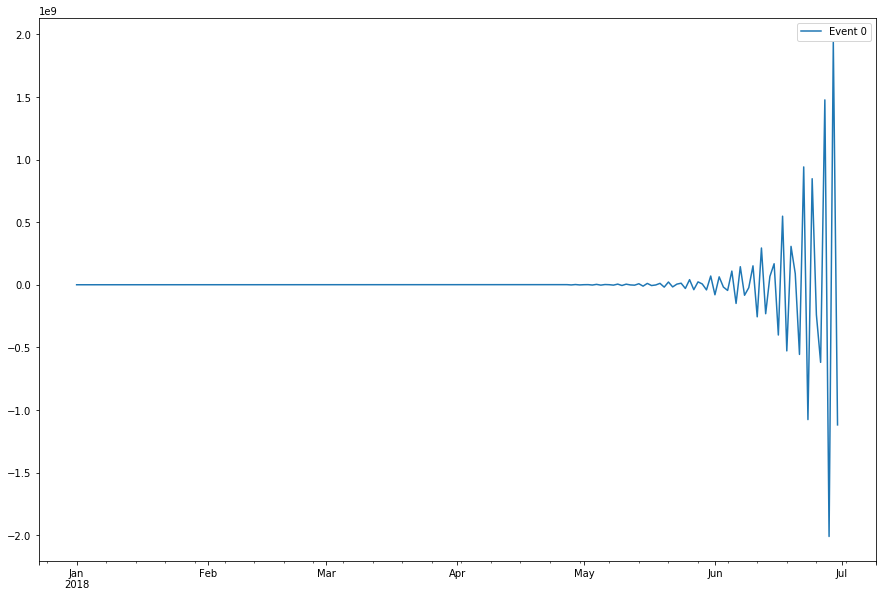

In [5]:
model = ClassicModels.ar(4)
generate_and_plot(model, n=1)

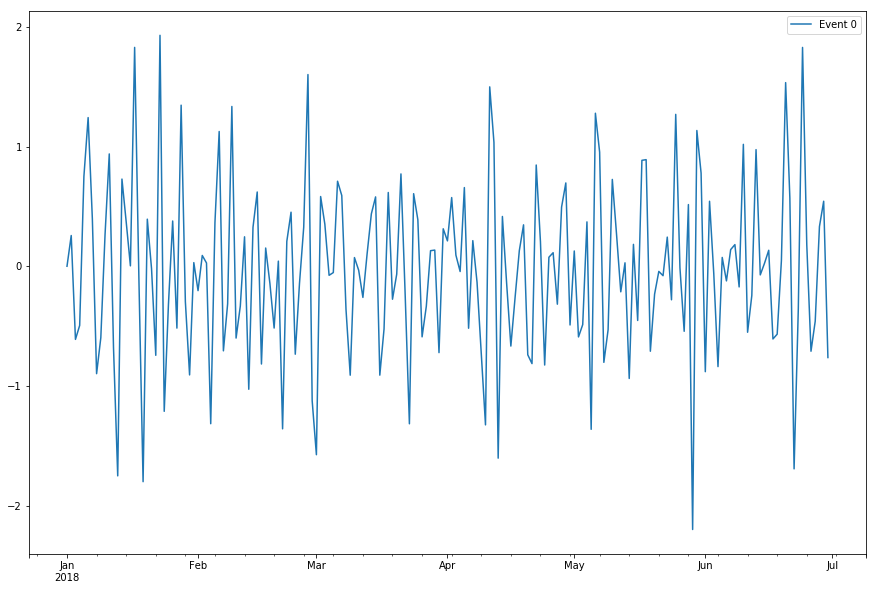

In [6]:
model = ClassicModels.ma(4)
generate_and_plot(model, n=1)

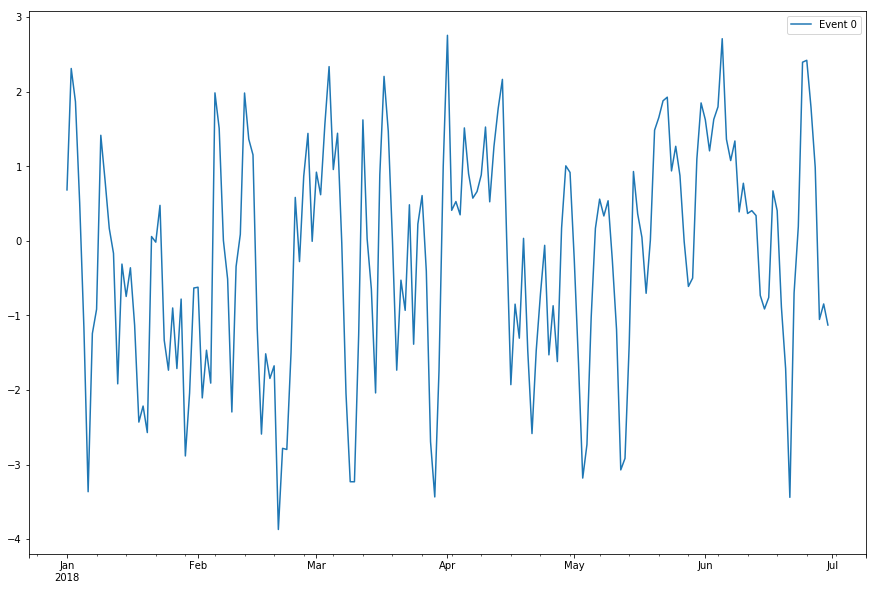

In [24]:
model = ClassicModels.arma(4, 2)
generate_and_plot(model, n=1)

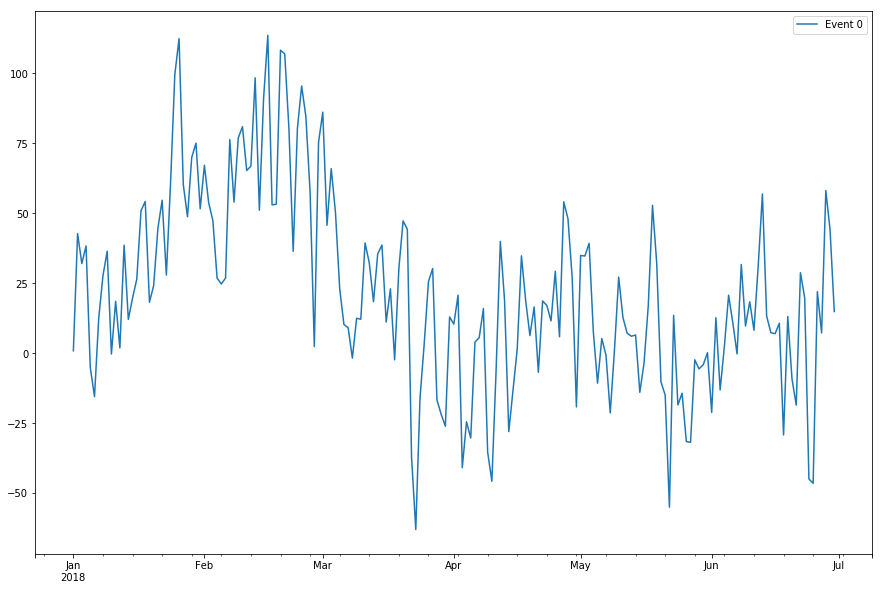

In [8]:
model = ClassicModels.ar(6, error_std=10, coefs=[0.5, 0, 0, 0.3, 0.1, 0.1])
generate_and_plot(model, n=1)

### Banking

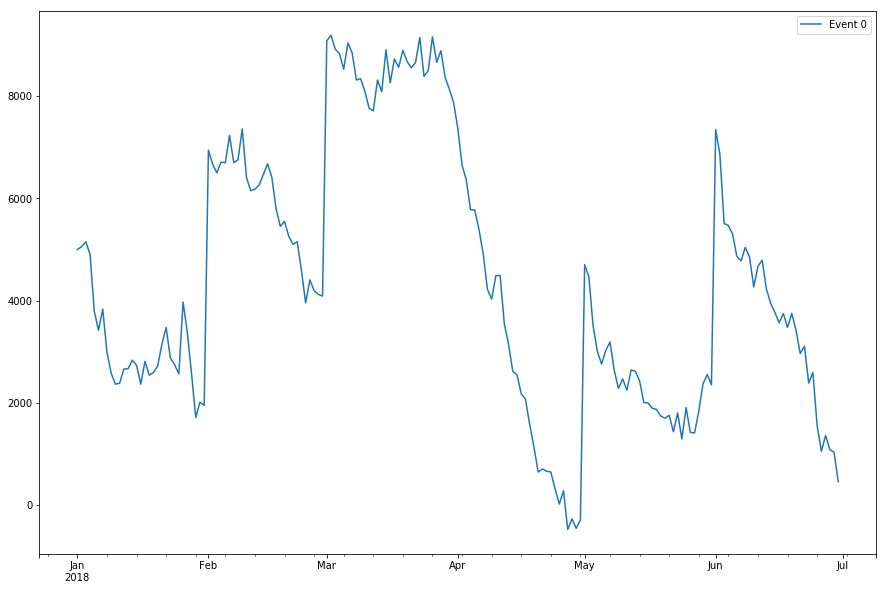

In [9]:
model = BankingModels.salary_earner()
generate_and_plot(model, n=1)

### Economics

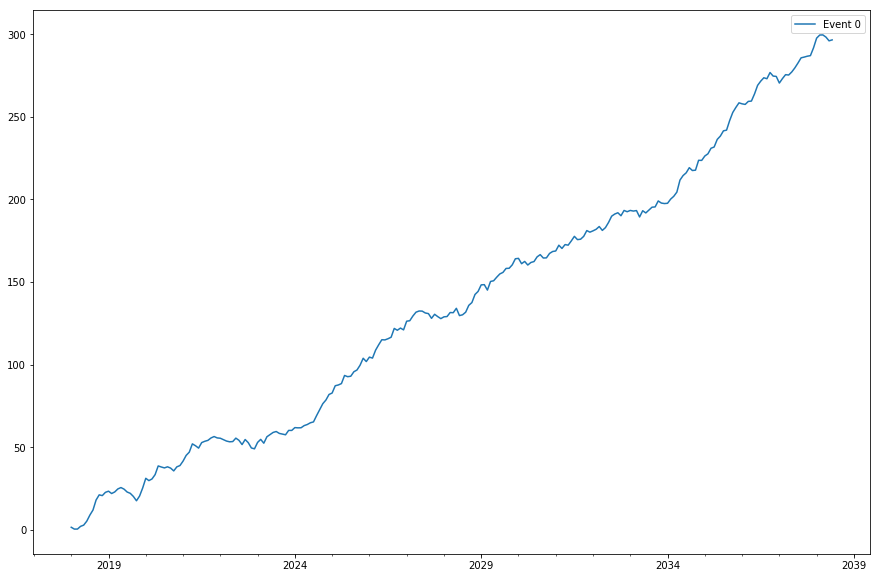

In [10]:
model = EconomicModels.kondratiev_business_cycle(base = 0.0, growth_mean = 1, growth_sd = 2,
                                                 wave_period= 72, wave_amplitude = 0.05)

generate_and_plot(model, n=1, end_date=pd.Timestamp(2038, 6, 30), freq='MS')

### Ecology 

The predator-prey relationship, as defined by so-called [Lotka–Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), is a classical ecological model. The equations are continuous, but here a discrete version is provided. Despite their simplicity, the behavior is actually quite surprising, owing to chaotic dynamics. For example, consider this first model.

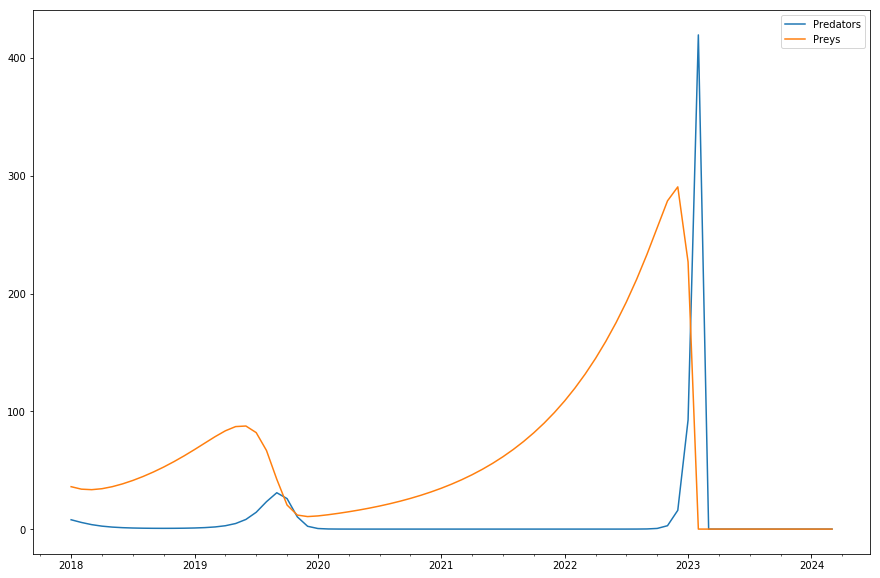

In [11]:
predators_model, preys_model = EcologyModels.predator_prey(n_predators=10, n_preys=40,
                                                                   alpha=1.1, beta=0.02, delta=0.02, gamma=0.008)


data = generate_and_plot([predators_model,preys_model], start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2024, 3, 30), 
                  freq='MS')

Now let us increase the `delta` parameter, which controls the predators' reproduction, in order to observe  different result. 

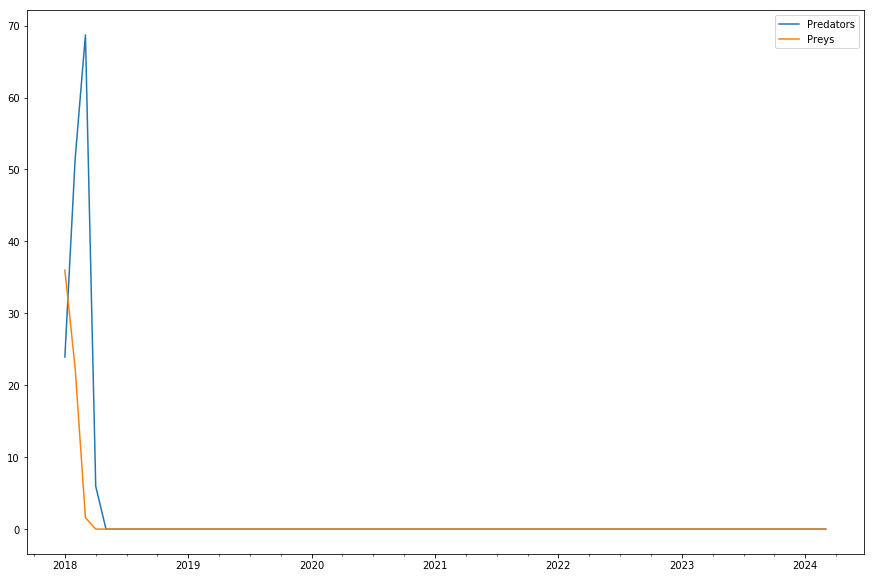

In [12]:
predators_model, preys_model = EcologyModels.predator_prey(n_predators=10, n_preys=40,
                                                                   alpha=1.1, beta=0.02, delta=0.06, gamma=0.008)


data = generate_and_plot([predators_model,preys_model], start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2024, 3, 30), 
                  freq='MS')

We see that the predators reproduce so efficiently that there is no time to allow the prey population to recover, causing both to be quickly extinct.

## Custom Models
The above predefined models are built using events provided by TimeBlender. Here, we will see some of these and how to combine them.

### Model Addition

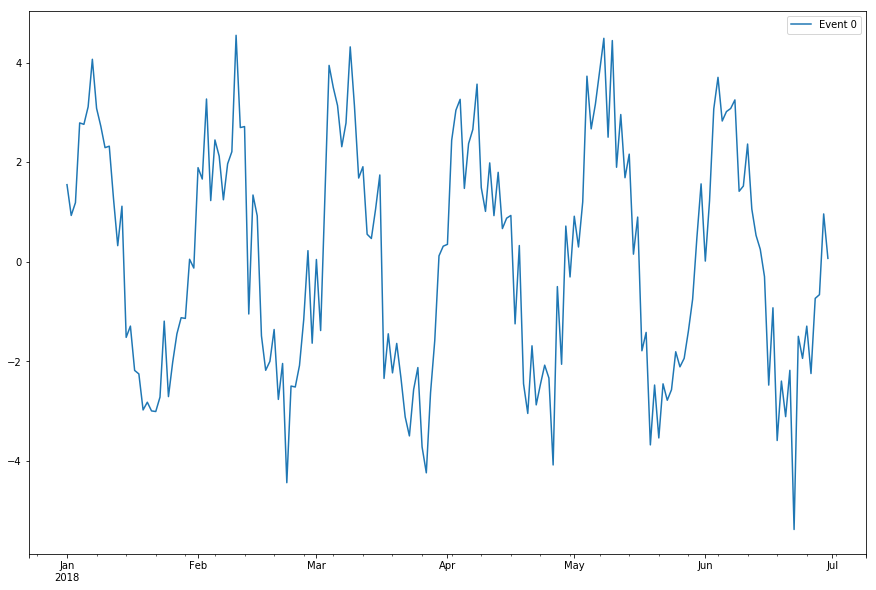

In [13]:
norm = NormalEvent(0, 1)
we = WaveEvent(30, 3)

compos = norm + we

generate_and_plot(compos)

### Random Walk

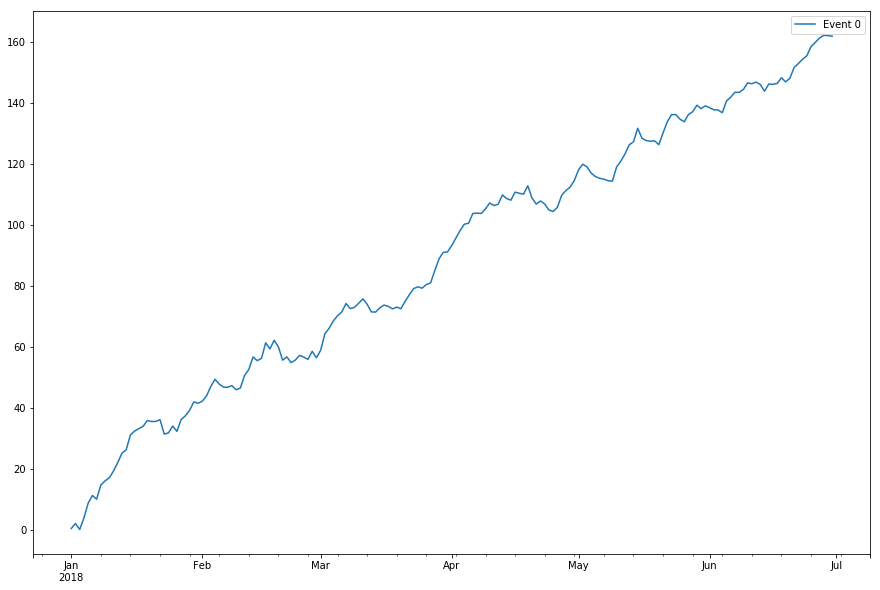

In [14]:
model = WalkEvent(0, NormalEvent(1, 2))
generate_and_plot(model, n=1)

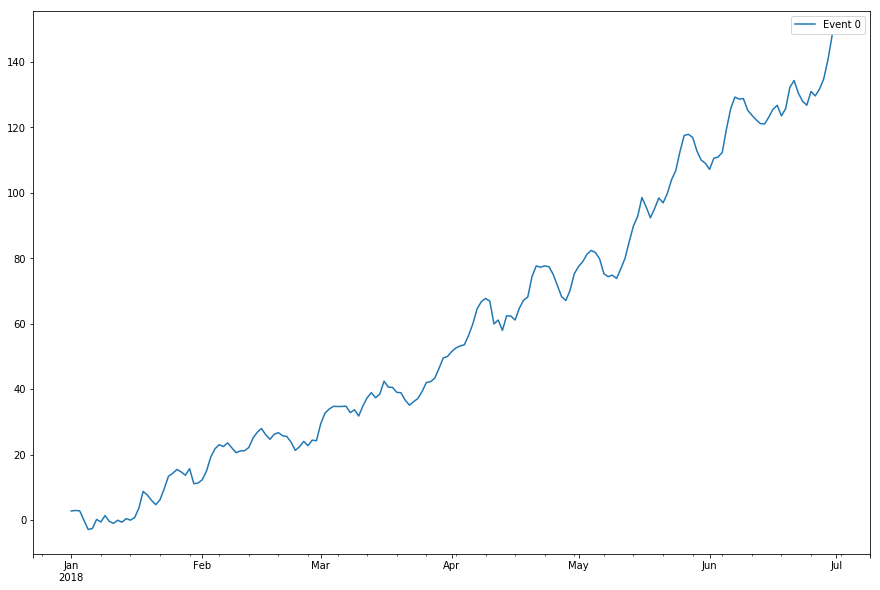

In [15]:
we = WaveEvent(12, 0.05)
model = WalkEvent(0, NormalEvent(1, 2)) * (ConstantEvent(1) + we)
generate_and_plot(model, n=1)

### More Complex Functional Compositions

Let's model a series that changes its behavior once, and such that each new behavior is itself a composition.

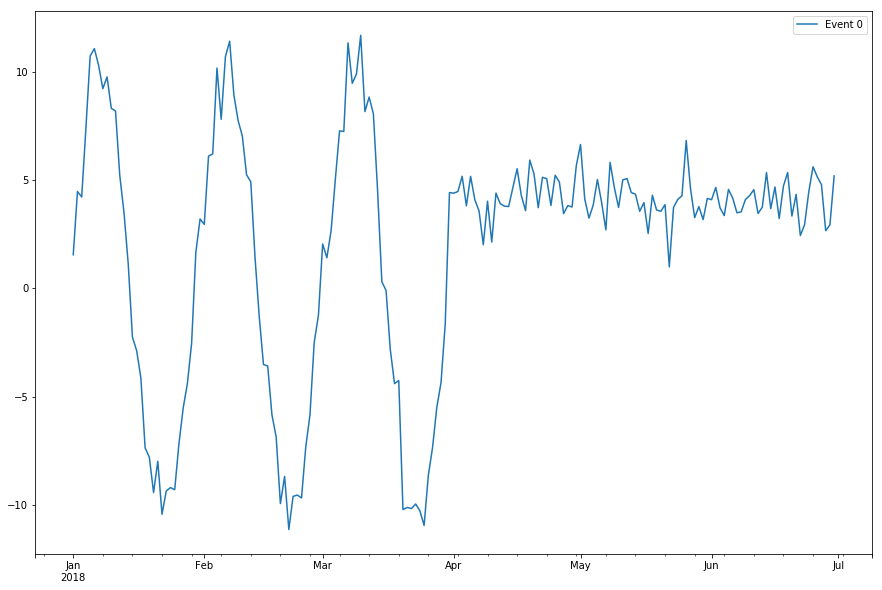

In [16]:
const = ConstantEvent(4)
norm = NormalEvent(0, 1)
we = WaveEvent(30, 10)
t_change = Once(UniformEvent(0, 90))

compos1 = we + norm
compos2 = const + norm

def aux(t, i, memory):
    if i <= t_change.execute(t):
        return compos1.execute(t)
    else:
        return compos2.execute(t)

e = LambdaEvent(aux)

generate_and_plot(e)

We can also implement such regime change using the `Piecewise` event.

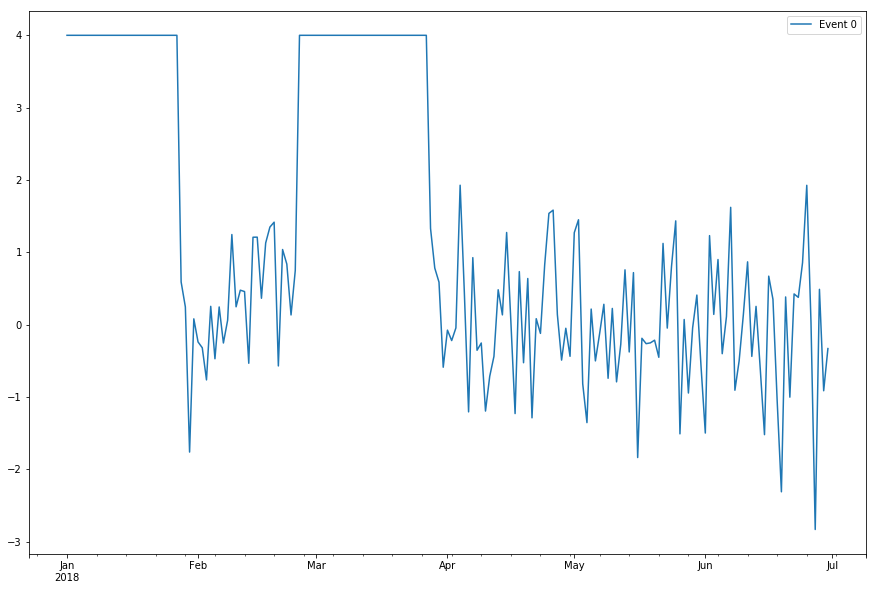

In [17]:
const = ConstantEvent(4)
norm = NormalEvent(0, 1)
#we = WaveEvent(30, 10)

model = Piecewise([const, norm, const, norm],  t_separators=[NormalEvent(30, 5), 
                                                             NormalEvent(60, 5), 
                                                             NormalEvent(90, 5)])

generate_and_plot(model)

We have seen so far arithimetic and piecewise combination. It is also possible, however, to implement more complex interactions. Here, we will define a top resistance with respect to a random walk. Note that, for this to work, the value after the resistance must be passed back to the underlying random walk event. This is achieved transparently.

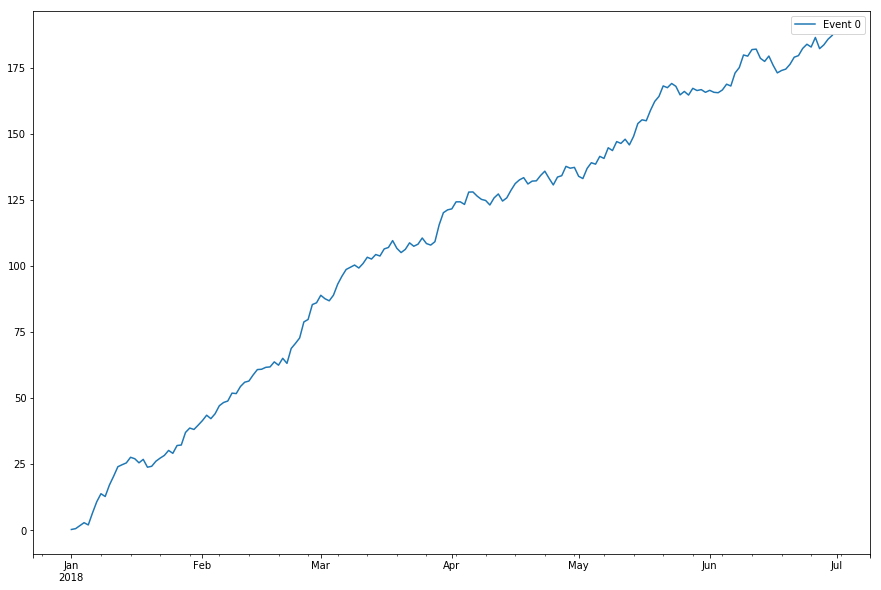

In [18]:
base = WalkEvent(0, NormalEvent(1, 2))
resistance_1 = NormalEvent(0.5, 0.1)
model = TopResistance(base, 
                      resistance_value_begin=50,
                      resistance_value_end=55,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1)

generate_and_plot(model)

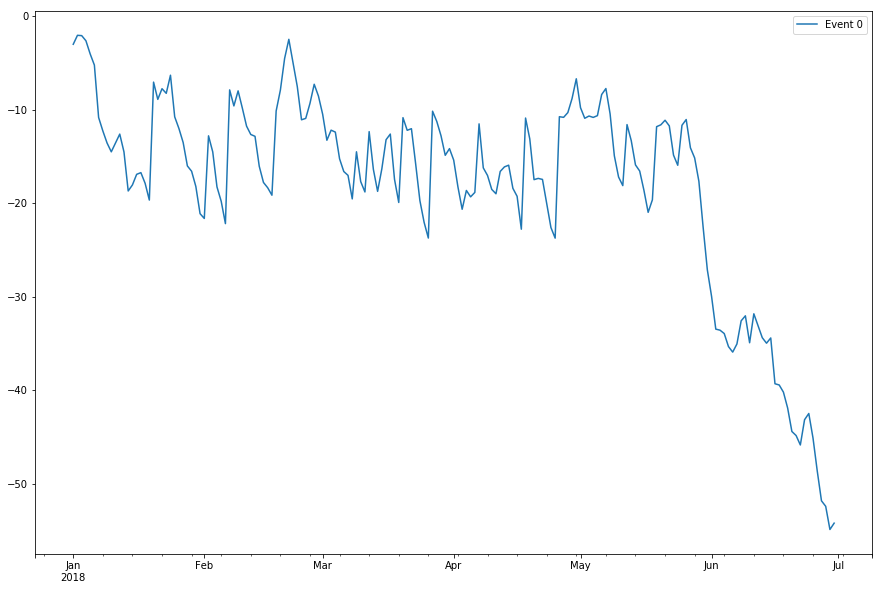

In [19]:
base = WalkEvent(0, NormalEvent(-1, 2))
resistance_1 = NormalEvent(0.5, 0.1)
model = BottomResistance(base, 
                      resistance_value_begin=-20,
                      resistance_value_end=-30,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1)

generate_and_plot(model)

Multiple resistance levels can be defined.

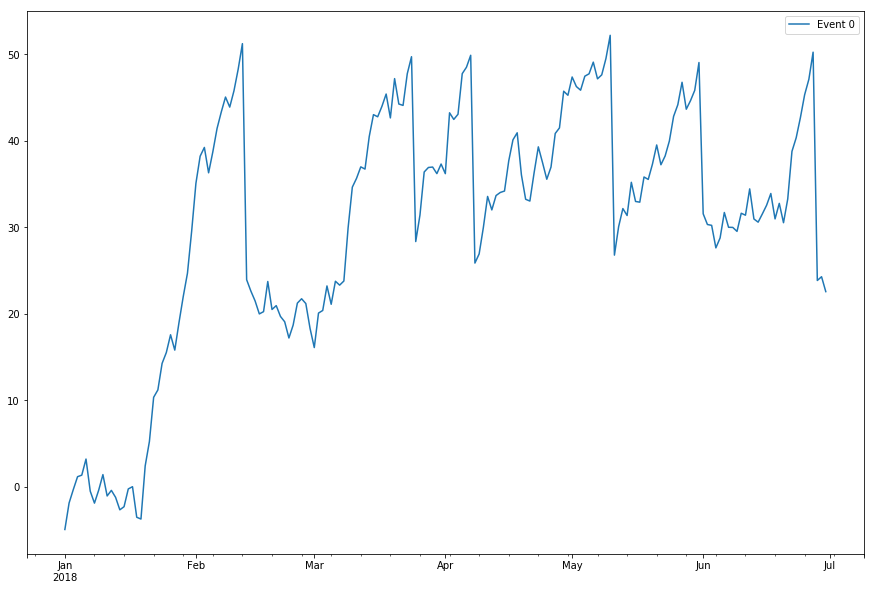

In [20]:
base = WalkEvent(0, NormalEvent(1, 2))
resistance_1 = NormalEvent(0.5, 0.1)

model = \
    TopResistance(
        TopResistance(base, 
                      resistance_value_begin=50,
                      resistance_value_end=55,
                      resistance_probability=0.5, 
                      resistance_strength_event=resistance_1),
        resistance_value_begin=80,
        resistance_value_end=85,
        resistance_probability=0.5, 
        resistance_strength_event=resistance_1)
    

generate_and_plot(model)

We can also use both bottom and top resistance, for instance to insert extra infornation in an AR model supposed to simulate a stock market.

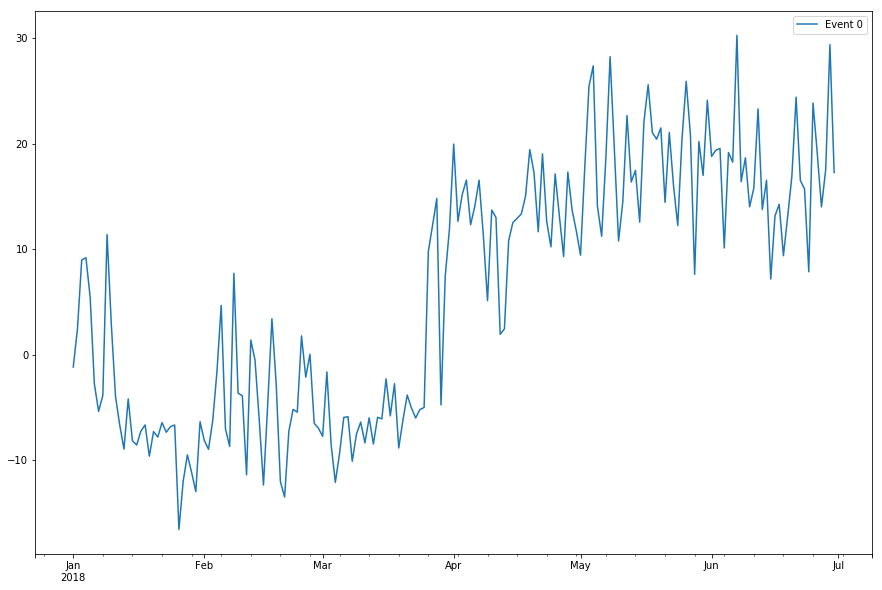

In [21]:
base = ClassicModels.ar(6, error_std=3, coefs=[0.5, 0, 0, 0.3, 0.1, 0.1])
resistance_1 = NormalEvent(0.5, 0.1)

model = \
    BottomResistance(
            TopResistance(base, 
                          resistance_value_begin=20,
                          resistance_value_end=80,
                          resistance_probability=0.999, 
                          resistance_strength_event=resistance_1),
        resistance_value_begin=-10,
        resistance_value_end=-80,
        resistance_probability=0.999, 
        resistance_strength_event=resistance_1)

generate_and_plot(model, n=1)

This shows how existing models can be enriched to achieve more detailed effects.

## Exporting Data

The generated data is given as Pandas Series, so the usual Pandas mechanisms can be used both to customize and to export the generated data. 

In [22]:
data = generate(model,start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                      n=1, freq='D')

In [23]:
data[0].to_csv('example_output.csv')
data[0]

,Event 0
2018-01-01,1.665542
2018-01-02,-3.640606
2018-01-03,12.263210
2018-01-04,16.859702
2018-01-05,6.021499
2018-01-06,2.843580
2018-01-07,0.138656
2018-01-08,0.391534
2018-01-09,8.197586
2018-01-10,5.446612
